# Первая домашка: Титаник

Импортирую нужные модули, загружаю датасет.

In [16]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
titanic = sns.load_dataset("titanic")

## 1. Графики!!1

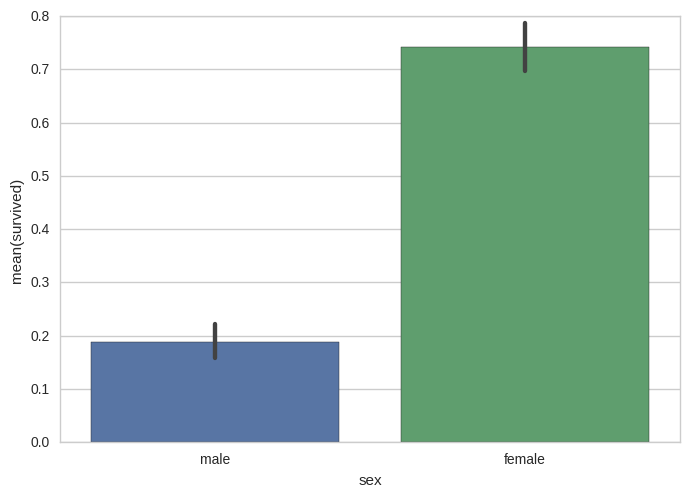

In [3]:
sns.set(style="whitegrid", color_codes=True)
np.random.seed(sum(map(ord, "categorical")))
sns.barplot(x="sex", y="survived", data=titanic)
plt.show()

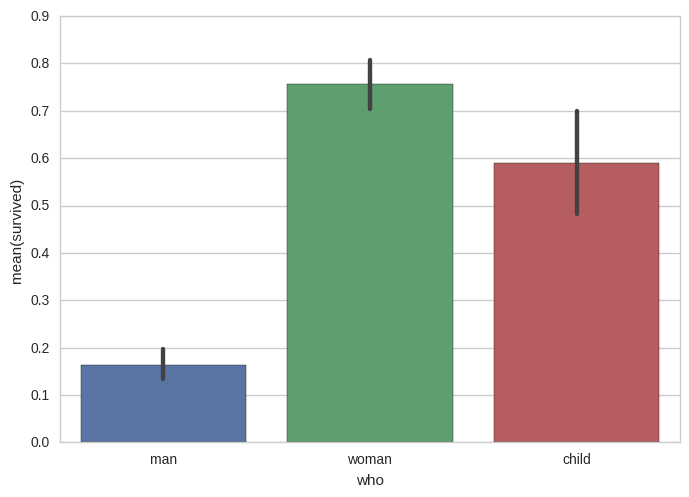

In [42]:
sns.barplot(x="who", y="survived", data=titanic)
plt.show()

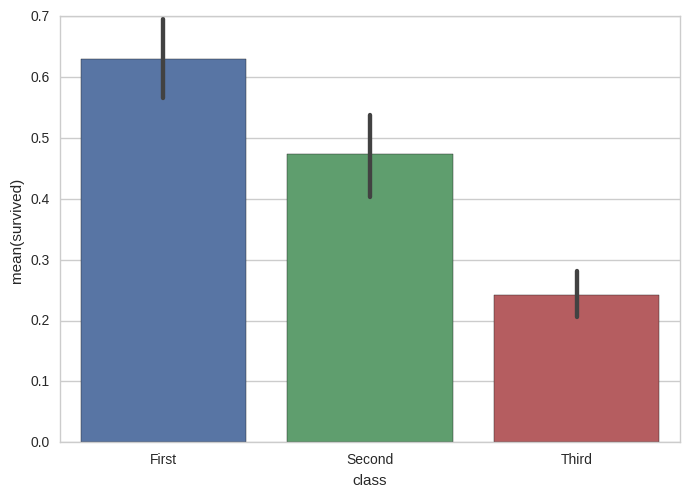

In [23]:
sns.barplot(x="class", y="survived", data=titanic)
plt.show()

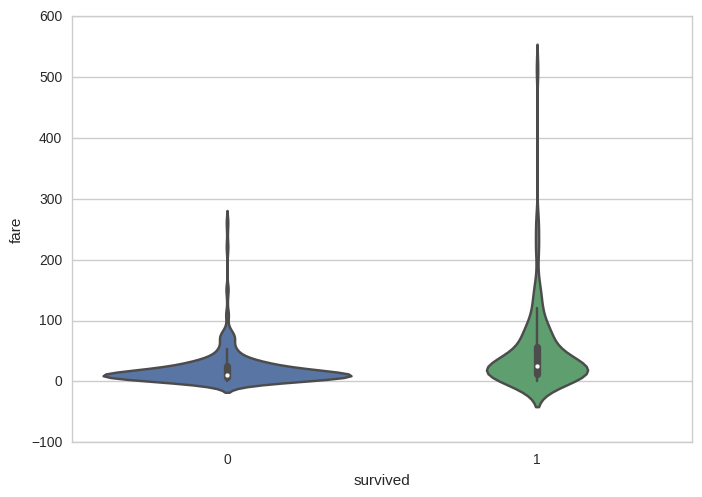

In [41]:
sns.violinplot(x="survived", y="fare", data=titanic)
plt.show()

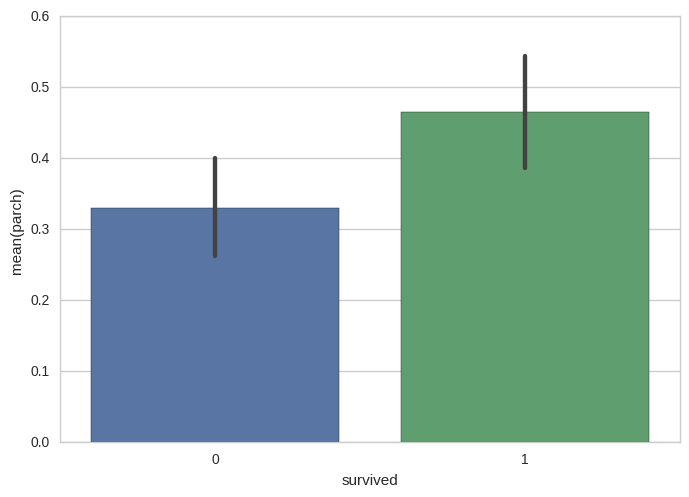

In [35]:
sns.barplot(x="survived", y="parch", data=titanic)
plt.show()

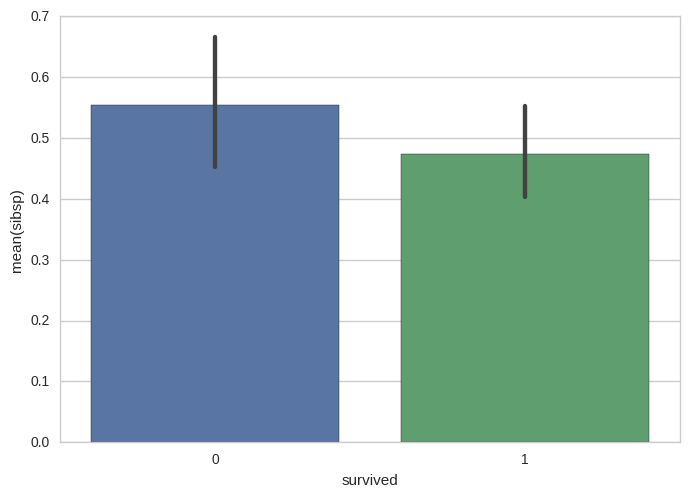

In [47]:
sns.barplot(x="survived", y="sibsp", data=titanic)
plt.show()

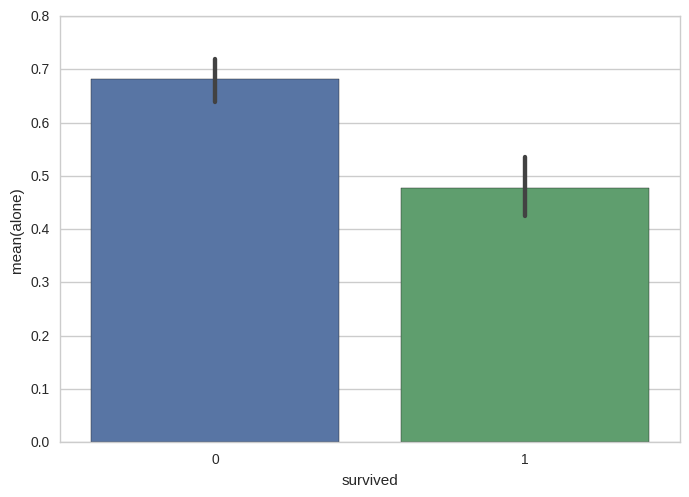

In [46]:
sns.barplot(x="survived", y="alone", data=titanic)
plt.show()

Интерпретация:
* вероятность выжить на титанике, если ты женщина, выше
* у тебя также довольно высока вероятность выжить, если ты ребёнок
* чем выше у тебя класс, тем выше вероятность выжить на титанике
* среди выживших значительно меньше тех, кто платил за билет не очень много; все, кто заплатил за билет больше 300, выжили
* у выживших было в среднем больше родителей на борту
* у невыживших было в среднем больше сиблингов на борту
* среди невыживших было в среднем больше одиноких

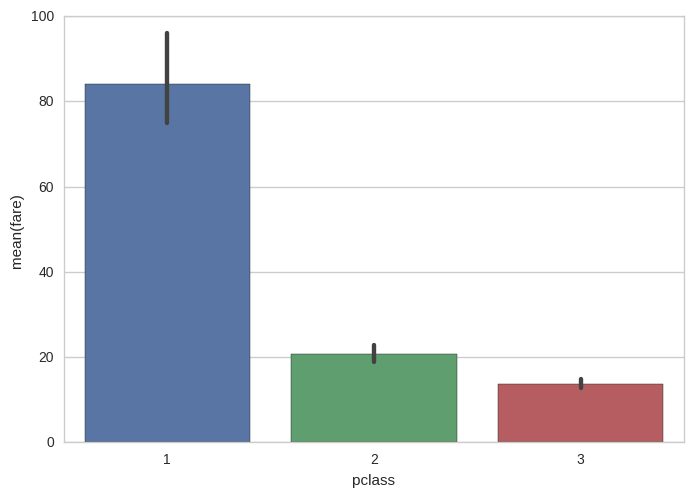

In [29]:
sns.barplot(x="pclass", y="fare", data=titanic)
plt.show()

Интерпретация: билеты дороже всего у пассажиров первого класса, причём с сильным отрывом. Стоимость билетов у пассажиров 2 и 3 класса не сильно различается, но у 2 класса несколько выше, чем у 1. Здесь очень хорошо видно, что переменные pclass и fare не являются независимыми.

## 2. Два предиктора.

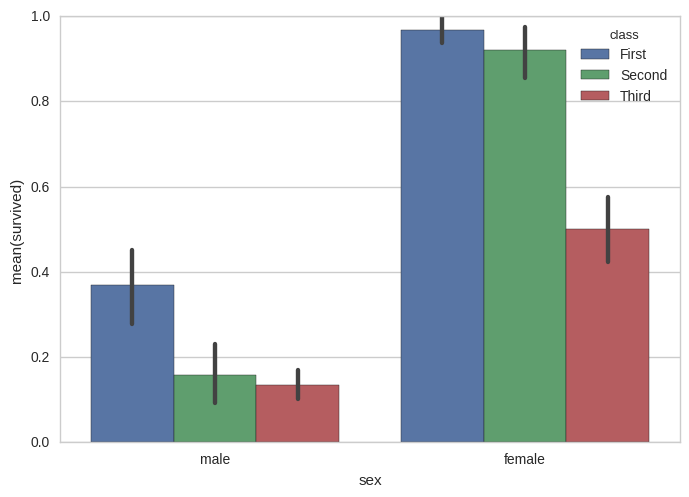

In [18]:
sns.barplot(x="sex", y="survived", hue="class", data=titanic)
plt.show()

Выше всего вероятность выжить, если ты женщина первого или второго класса. Впрочем, даже у женщин 3 классы верорятность выжить выше, чем у мужчин 1 класса.
Меньше всего вероятность выжить, если ты мужчина 2 или 3 класса.

## 3. Чищу данные.

In [17]:
titanic_y = titanic['survived']
titanic_x = titanic.loc[:, ('pclass', 'sex', 'age', 'alone')]

# заменяю значения NaN на среднее арифметическое
m = titanic_x['age'].mean()
titanic_x['age'] = titanic_x['age'].fillna(value=m)

# заменяю значения переменной sex на логические
sex = titanic_x['sex']
titanic_x['sex'] = pd.get_dummies(sex)['male']

titanic_x.tail()

,pclass,sex,age,alone
886,2,1.0,27.000000,True
887,1,0.0,19.000000,True
888,3,0.0,29.699118,False
889,1,1.0,26.000000,True
890,3,1.0,32.000000,True


У меня не получилось найти такой пятый параметр, который имел бы значение, и был бы независимым.

## 4. Деревья решений

In [21]:
fold = round(len(titanic_y)/10)
for i in range(10):
    test_x, train_x = titanic_x[fold * i: fold * (i + 1)], 

89


## 5. Рандомный лес